# Surrogate Construction for Genz Functions
## As a function of the number of quadrature points

This notebook constructs a PC surrogate for Genz functions using full and sparse quadrature, giving the root mean square error between the surrogate and the actual function.

In [1]:
# imports
import numpy as np
import math  
import matplotlib.pyplot as plt
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

In [2]:
nord = 4            # Order of the PCE
pc_type = "HG"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
nSam = 100000       # Number of random samples
ndim = 2            # Number of dimensions
model= 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'
q_pts = 10          # Maximum number of quad points per dimension
coef = "regression"

We define the range of quadrature points we will be using.

In [3]:
num_points=range(1,q_pts+1)
tot_pts=[i**ndim for i in num_points]

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


## Full Quadrature

We loop through different values of the number of quadrature points per dimension, performing full quadrature on each and obtaining the RMSE.

In [5]:
q_errors=[] #list to store quad errors

#Loop though different values for number of quad points per dimension
for quad_param in num_points:
    pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
    pc_model.SetQuadRule(pc_type, 'full', quad_param) # set full or sparse
    qdpts, totquat= pce_tools.UQTkGetQuadPoints(pc_model)
    f_evals=func(qdpts,model,np.ones(ndim+1))
    
    if (coef=="regression"):
        c_k = pce_tools.UQTkRegression(pc_model, f_evals)
    elif (coef=="galerkin"):
        c_k = pce_tools.UQTkGalerkinProjection(pc_model,f_evals)
    else:
        print("Invalid coef chosen. Galerkin projection is used by deafult.)
        c_k = pce_tools.UQTkGalerkinProjection(pc_model,f_evals)
        
    
    germ_samples=np.random.normal(0,1, (nSam,ndim))
    pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)
    f_actual=func(germ_samples,model,np.ones(ndim+1))
    MSE = np.square(np.subtract(f_actual,pce_evals)).mean()
    RMSE=math.sqrt(MSE)
    q_errors.append(RMSE)

## Sparse Quadrature

We do the same for sparse quadrature.

In [6]:
q_errors2=[] #list to store quad errors

#Loop though different values for number of quad points per dimension
for quad_param in num_points:
    pc_model2 = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
    pc_model2.SetQuadRule(pc_type, 'sparse', quad_param)
    qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)
    f_evals2=func(qdpts2,model,np.ones(ndim+1))
    
    if (coef=="regression"):
        c_k2 = pce_tools.UQTkRegression(pc_model2, f_evals2)
    elif (coef=="galerkin"):
        c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,f_evals2)
    else:
        print("Invalid coef chosen. Galerkin projection is used by deafult.)
        c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,f_evals2)
    
    germ_samples2=np.random.normal(0,1, (nSam,ndim))
    pce_evals2=pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,germ_samples2)
    f_actual2=func(germ_samples2,model,np.ones(ndim+1))
    MSE2 = np.square(np.subtract(f_actual2,pce_evals2)).mean()
    RMSE2=math.sqrt(MSE2)
    q_errors2.append(RMSE2)

## Summary
This table and figure display the error of each method of quadrature as the total quadrature points varies.

In [7]:
pd.DataFrame(data=np.transpose([tot_pts,q_errors, q_errors2]), columns=["Num Quad Points", "Full", "Sparse"])

,Num Quad Points,Full,Sparse
0,1.0,0.845997,0.355061
1,4.0,0.481774,0.025066
2,9.0,0.104275,0.010800
3,16.0,0.013254,0.009889
4,25.0,0.011417,0.010411
5,36.0,0.009570,0.009728
6,49.0,0.010298,0.011641
7,64.0,0.010503,1.366602
8,81.0,0.010665,1.302191
9,100.0,0.010345,1.299934


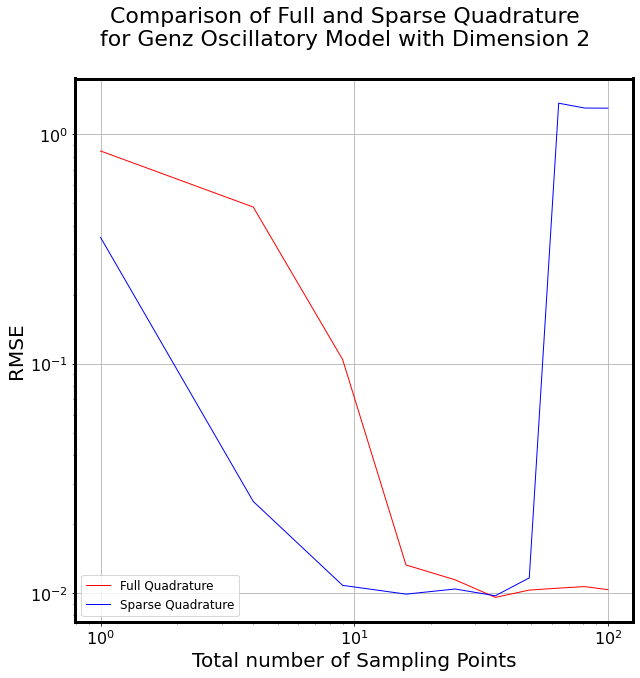

In [8]:
#Create figure
fig, ax = plt.subplots(figsize=(10,10))
#Plot Quadrature Data
plt.plot(tot_pts, q_errors, color='r', label='Full Quadrature')
plt.plot(tot_pts, q_errors2, color='b', label='Sparse Quadrature')
#Label Axes
plt.xlabel("Total number of Sampling Points",fontsize=20)
plt.ylabel("RMSE",fontsize=20)
#Create legend
plt.legend(loc='lower left')

#Model titles to be displayed
if model=="genz_osc":
    model_title="Genz Oscillatory"
elif model=="genz_gaus":
    model_title="Genz Gaussian"
elif model=="genz_ppeak":
    model_title="Genz Product-Peak"
elif model=="genz_cpeak":
    model_title="Genz Corner-Peak"
elif model=="genz_exp":
    model_title="Genz Exponential"
else:
    model_title="Genz Continuous"

#Add title
fig.suptitle("Comparison of Full and Sparse Quadrature\nfor %s Model with\
 Dimension %s"%(model_title, str(ndim)), fontsize=22)
#Make scales logarithmic
plt.yscale('log')
plt.xscale('log')
#Change size of tick labels
plt.tick_params(axis='both', labelsize=16)

#Show figure
plt.show() 